In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dython as dy
import plotly.express as px
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MultiLabelBinarizer, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, train_test_split
from xgboost import XGBRegressor
import plotly.figure_factory as ff
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

In [2]:
df = pd.read_csv('./data/dataset.csv')
# Setting id as index
df.set_index('id', inplace=True)

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df.values, df.fertilizer_usage.values):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

X_train = train_set.drop(columns='yield')
y_train = train_set['yield']
X_test = test_set.drop(columns='yield')
y_test = test_set['yield']

In [9]:
# Custom Transformer that extracts columns passed as argument to its constructor
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor
    def __init__( self, feature_names):
        self.feature_names = feature_names

    #Return self nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[self.feature_names]

In [79]:
# Will handle water, uv, area, pesticides- fill missing values and scale

class NumericalTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self):
        pass

    #Return self, nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Custom transform method we wrote that creates aformentioned features and drops redundant ones
    def transform(self, X, y = None):

        for col in X.columns:
            # Adjusting outliers with their percentile values
            low = X[col].quantile(0.01)
            high = X[col].quantile(0.99)

            X[col] = np.where(X[col] < low, low,X[col])
            X[col] = np.where(X[col] > high, high,X[col])

            # # Filling the Missing Values
            # X[col] = X.groupby('region')[col].transform(lambda x: x.fillna(x.mean()))
        self.num_columns = X.columns
        #returns a numpy array
        return X.values

In [80]:
# Now categorical variables

class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass

    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self

    #Transformer method we wrote for this transformer
    def transform(self, X , y = None ):
        #Depending on constructor argument break dates column into specified units
        #using the helper functions written above
        X = pd.get_dummies(X, columns=['region'], dtype=np.int64)

        # Splitting the entries so that it can be ingested to binarizer
        X['categories'] = X['categories'].transform(lambda x: x.split(','))

        mlb = MultiLabelBinarizer()
        cats = pd.DataFrame(mlb.fit_transform(X['categories']),columns=mlb.classes_, index=X.index)

        # Renaming the column value
        cats.columns = 'pesticide_' + cats.columns.values
        X = pd.concat([X.drop(columns='categories'), cats], axis=1)
        self.cat_columns = X.columns
        #returns numpy array
        return X.values

In [81]:
# Numerical features to pass down the numerical pipeline
numerical_features = ['water', 'uv', 'area', 'pesticides']

# Categorical features to pass donw the categorical pipeline
categorical_features = ['fertilizer_usage', 'region', 'categories']

#Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),

                                  ( 'num_transformer', NumericalTransformer() ),
                                    ('imputer', SimpleImputer(strategy = 'median') ),

                                  ( 'std_scaler', RobustScaler() ) ] )


#Defining the steps in the categorical pipeline
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),

                                  ( 'cat_transformer', CategoricalTransformer() )] )


#Combining numerical and categorical pipeline into one full big pipeline horizontally
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ),

                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

Preprocessing pipeline is ready for action

Let us test it.

In [82]:
# Now we can add Models to the pipeline with a new pipeline

model = Pipeline(steps=[('preprocessor', full_pipeline),
                        ('model', XGBRegressor())])

FeatureUnion(transformer_list=[('categorical_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=['fertilizer_usage',
                                                                                'region',
                                                                                'categories'])),
                                                ('cat_transformer',
                                                 CategoricalTransformer())])),
                               ('numerical_pipeline',
                                Pipeline(steps=[('num_selector',
                                                 FeatureSelector(feature_names=['water',
                                                                                'uv',
                                                                                'area',
                                                               

In [97]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('categorical_pipeline',
                                                 Pipeline(steps=[('cat_selector',
                                                                  FeatureSelector(feature_names=['fertilizer_usage',
                                                                                                 'region',
                                                                                                 'categories'])),
                                                                 ('cat_transformer',
                                                                  CategoricalTransformer())])),
                                                ('numerical_pipeline',
                                                 Pipeline(steps=[('num_selector',
                                                                  FeatureSelector(feature_names=['water',
                                  

array([ 63.554523 ,  22.413559 ,  74.66881  ,  96.53767  ,  53.915504 ,
        52.493343 ,  68.34212  ,  60.214985 ,  89.76018  ,  77.481964 ,
        29.804348 ,  76.86588  ,  85.59925  ,  84.90035  ,  42.402657 ,
        93.85431  , 110.07837  ,  48.48818  ,  74.92908  , 118.890564 ,
        55.254864 , 108.16543  , 104.95489  ,  80.335075 ,  55.16112  ,
        35.760834 ,  27.217163 ,  80.71355  ,  59.035423 ,  47.60036  ,
        79.65083  ,  49.32962  ,  39.54636  ,  99.02942  ,  65.260994 ,
        64.70298  ,  57.065    ,  46.63255  ,  49.688797 ,  70.078514 ,
        34.653324 ,  32.015278 ,  64.4864   ,  84.209274 ,  46.6324   ,
        69.81306  ,  69.80854  ,  51.609295 ,  28.911932 ,  68.906334 ,
        41.01254  ,  76.796425 ,  64.273994 ,  29.861624 ,  33.995064 ,
        56.900997 ,  58.35324  ,  97.51384  ,  49.98211  ,  42.77085  ,
        44.470886 ,  54.691727 ,  74.83789  ,  67.59571  ,  35.09203  ,
        41.10578  , 108.75281  ,  24.702753 ,  44.551483 ,  22.7

In [101]:
print(f'Testing score: {model.score(X_train, y_train)}')
print(f'Testing score: {model.score(X_test, y_test)}')
print(r2_score(y_test, model.predict(X_test)))

Testing score: 0.9997262737476746
Testing score: 0.8700104324538045


<AxesSubplot:>

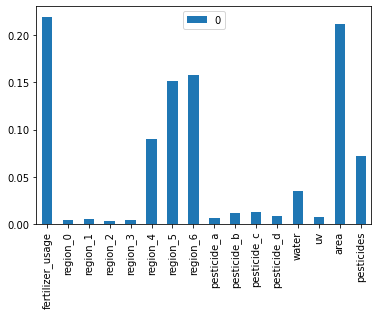

In [145]:
# Feature Importance

# Column List for cat
cols = list(full_pipeline.transformer_list[0][1][1].cat_columns) + list(full_pipeline.transformer_list[1][1][1].num_columns)

dt = pd.DataFrame(data=model.steps[1][1].feature_importances_).transpose()
dt.columns = cols
dt.transpose().plot(kind='bar')

In [173]:
# Adding Gridsearch CV to the model

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

def train_estimator(estimator):
    best_estimators = {}
    for clf, params in tqdm(estimator.items()):
        model_svr = Pipeline(steps=[('preprocessor', full_pipeline),
                                    ('clf', clf)])
        gsc = GridSearchCV(
                estimator= model_svr,
                param_grid=params,
                cv=5, scoring='r2', verbose=0, n_jobs=-1)

        gsc.fit(X_train, y_train)
        # best params and model
        gsc.best_params_
        best_estimator = gsc.best_estimator_
        best_estimators[clf] = best_estimator.named_steps['clf']
    return gsc, best_estimators

In [174]:
regressors = {SVR(): {
                'clf__C': [0.1, 1, 100, 1000],
                'clf__epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
                'clf__gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
            },
            XGBRegressor():{


            }
}

In [175]:
gsc, estimators = train_estimator(regressors)

100%|██████████| 1/1 [00:17<00:00, 17.73s/it]


In [188]:
gsc.score(X_test, y_test)

0.902513103205044

Now Hyperopt as Hypertuning technique

In [217]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import xgboost as xgb

def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    regressor = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree']
                            )

    # hyper_pipe = Pipeline(steps=[('preprocessor', full_pipeline),
    #                              {'regressor', regressor}])

    regressor.fit(full_pipeline.fit_transform(X_train,y_train),y_train.to_numpy())
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = regressor, X = full_pipeline.fit_transform(X_train,y_train),
                                 y = y_train.to_numpy(), cv = 10, scoring='r2')
    CrossLoss = accuracies.mean()
    print("Acc Mean:", CrossLoss)

    return{'loss':1 - CrossLoss, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)

Acc Mean:                                             
-1.0950942332364322                                   
Acc Mean:                                                                       
0.6795604853849365                                                              
Acc Mean:                                                                       
0.8522925059535901                                                              
Acc Mean:                                                                        
0.6932066399525834                                                               
Acc Mean:                                                                        
0.8624648038567365                                                               
Acc Mean:                                                                        
0.8422554751570047                                                               
Acc Mean:                                                                 

In [220]:

# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
regressors = XGBRegressor(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

regressors.fit(full_pipeline.fit_transform(X_train,y_train), y_train.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9500000000000001,
             gamma=0.23, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.06, max_delta_step=0,
             max_depth=19, min_child_weight=9.0, missing=nan,
             monotone_constraints='()', n_estimators=17, n_jobs=6,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.71, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [221]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = regressors, X = full_pipeline.fit_transform(X_train,y_train), y = y_train.to_numpy(), cv = 10,
                             scoring='r2')
CrossValMean = accuracies.mean()
print("Final CrossValMean: ", CrossValMean)

CrossValSTD = accuracies.std()

Final CrossValMean:  -0.16562951841904971


In [222]:
# Predicting the Test set results
y_pred = regressors.predict(full_pipeline.transform(X_test))
y_pred = pd.DataFrame(y_pred)

In [224]:
r2_score(y_test, y_pred)

-0.054377073622303485